In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Layer
from tensorflow.keras.utils import to_categorical
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [3]:
# Veri yükleme
from sklearn.datasets import fetch_openml

# TSRB veri setini yükle
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])
# Veri setini indiriyoruz
tsrb = torchvision.datasets.GTSRB(
    root='./data', split='train', download=True, transform=transform)

# Veriyi DataFrame'e dönüştürelim
data_list = []

for img, label in tsrb:
    data_list.append((img.numpy().flatten(), label))

# DataFrame oluşturuyoruz
df = pd.DataFrame(data_list, columns=['features', 'label'])

# Veriyi kontrol ediyoruz
print(df.head(10))


100%|██████████| 187M/187M [00:09<00:00, 18.9MB/s]


Extracting data/gtsrb/GTSRB-Training_fixed.zip to data/gtsrb
                                            features  label
0  [0.29411766, 0.2901961, 0.3254902, 0.39607844,...      0
1  [0.27058825, 0.29411766, 0.29411766, 0.3019608...      0
2  [0.28235295, 0.30588236, 0.30588236, 0.4470588...      0
3  [0.26666668, 0.29803923, 0.34901962, 0.5529412...      0
4  [0.28627452, 0.2901961, 0.29411766, 0.43529412...      0
5  [0.2627451, 0.28627452, 0.42352942, 0.7176471,...      0
6  [0.2627451, 0.26666668, 0.3019608, 0.46666667,...      0
7  [0.2509804, 0.28627452, 0.40392157, 0.68235296...      0
8  [0.44705883, 0.78431374, 0.7372549, 0.654902, ...      0
9  [0.29803923, 0.5058824, 0.7176471, 0.73333335,...      0


In [4]:
# Null kontrolü yapıyoruz
print(df.isnull().sum())

features    0
label       0
dtype: int64


In [5]:
# Veri setini X (özellikler) ve y (etiketler) olarak ayırıyoruz
X = np.array(list(df['features']))
y = np.array(list(df['label']))

# Veriyi eğitim (%80) ve test (%20) kümelerine ayırıyoruz
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Şimdi X_train, X_test, y_train ve y_test değişkenlerinde eğitim ve test verilerimiz var.
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (21312, 3072)
y_train shape: (21312,)
X_test shape: (5328, 3072)
y_test shape: (5328,)


In [6]:
# Veri setini StandartScaler ile ölçeklendiriyoruz

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

MLP Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95        27
           1       0.96      0.97      0.97       291
           2       0.95      0.95      0.95       313
           3       0.96      0.92      0.93       212
           4       0.97      0.97      0.97       262
           5       0.94      0.96      0.95       261
           6       1.00      0.98      0.99        58
           7       0.98      0.94      0.96       191
           8       0.97      0.95      0.96       200
           9       0.98      0.98      0.98       203
          10       0.97      0.99      0.98       257
          11       0.98      0.96      0.97       176
          12       1.00      0.98      0.99       298
          13       0.98      0.98      0.98       310
          14       1.00      1.00      1.00       101
          15       0.95      0.95      0.95        86
          16       1.00      0.98      0.99        52


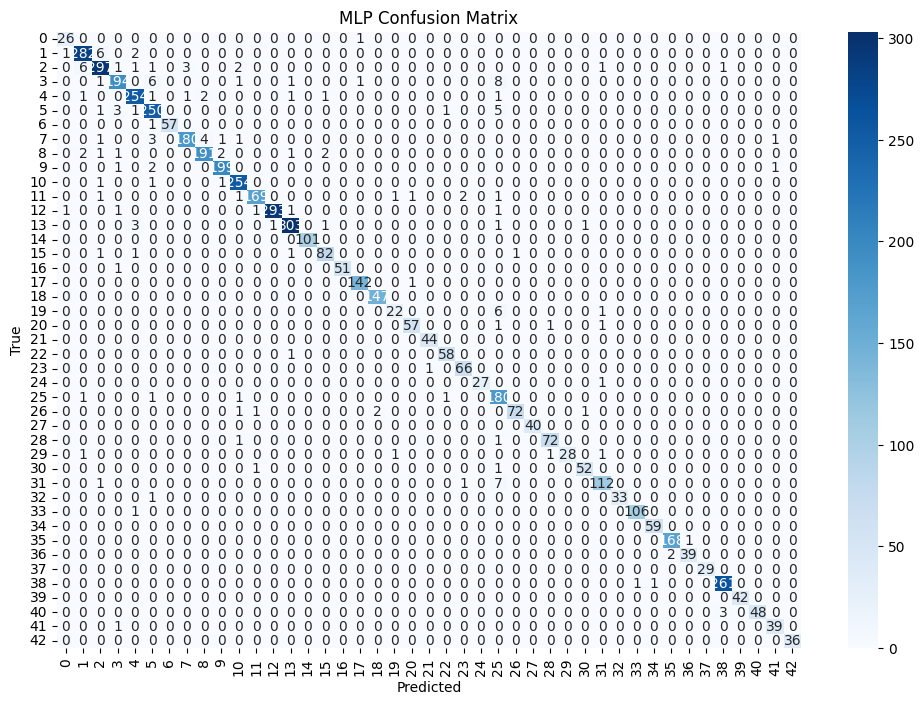

In [7]:
# MLP modelini oluşturuyoruz
# Parametreler;
# 100 nöron bulunan Tek hidden layer kullanılıyor
# Negatif değerleri 0'lamak için RELU aktivasyon fonksiyonu kullanılıyor
# Öğrenme oranını ADAPTIVE seçilmiştir. Hata oranını kendisi azaltacak
# 200 adım boyunca ağırlıklar güncellenecektir
mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', learning_rate='adaptive', max_iter=200)

# MLP modelini eğitiyoruz
mlp.fit(X_train, y_train)

# Eğitilen Test verileri üzerinde Tahmin yapılıyor
y_pred_mlp = mlp.predict(X_test)

# Performans değerlendirme yapılır
print("MLP Classification Report:")
print(classification_report(y_test, y_pred_mlp))

# Karışıklık matrisini oluşturuyoruz
cm_mlp = confusion_matrix(y_test, y_pred_mlp)

# Karışıklık matrisini Görselleştiriyoruz
plt.figure(figsize=(12, 8))
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('MLP Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [8]:
# MLP modeli için Randomize Search ile en iyi parametreler bulunuyor
# Gerekli kütüphaneler yükleniyor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
import numpy as np

# Hiperparametre dağılımları
# 3 farklı hidden layer,
# RELU ve TANH aktivasyon fonksiyonları ve
# ADAPTIVE ve CONSTANT öğrenme oranları seçilerek yapılıyor
param_distributions = {
    'hidden_layer_sizes': [ (100,), (100, 50), (150, 100, 50)],
    'activation': ['tanh', 'relu'],
    'learning_rate': ['constant', 'adaptive'],
}

# RandomizedSearchCV ile en iyi parametreleri bulunuyor
random_mlp = RandomizedSearchCV(
    MLPClassifier(max_iter=200),
    param_distributions,
    n_iter=20,  # Daha az sayıda deneme yaparak hızlandırıyoruz
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42  # Rastgeleliği kontrol etmek için
)
random_mlp.fit(X_train, y_train)

# En iyi parametreleri ve model performansını yazdır
print("En İyi Parametreler:", random_mlp.best_params_)

# En iyi modeli değerlendir
best_mlp = random_mlp.best_estimator_
y_pred_best_mlp = best_mlp.predict(X_test)

print("Best MLP Classification Report:")
print(classification_report(y_test, y_pred_best_mlp))

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


En İyi Parametreler: {'learning_rate': 'constant', 'hidden_layer_sizes': (100, 50), 'activation': 'relu'}
Best MLP Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94        27
           1       0.90      0.92      0.91       291
           2       0.95      0.90      0.92       313
           3       0.96      0.86      0.91       212
           4       0.95      0.95      0.95       262
           5       0.77      0.94      0.85       261
           6       0.98      1.00      0.99        58
           7       0.97      0.61      0.75       191
           8       0.74      0.96      0.83       200
           9       0.95      0.98      0.96       203
          10       0.98      0.91      0.94       257
          11       0.92      0.95      0.94       176
          12       0.96      0.93      0.94       298
          13       0.99      0.95      0.97       310
          14       1.00      0.89      0.94       1

Epoch 1/50
533/533 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.0534 - loss: 3.7169 - val_accuracy: 0.0549 - val_loss: 3.6203
Epoch 2/50
533/533 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0548 - loss: 3.5952 - val_accuracy: 0.0549 - val_loss: 3.5583
Epoch 3/50
533/533 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.0559 - loss: 3.5380 - val_accuracy: 0.0549 - val_loss: 3.5325
Epoch 4/50
533/533 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0568 - loss: 3.5109 - val_accuracy: 0.0549 - val_loss: 3.5223
Epoch 5/50
533/533 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.0589 - loss: 3.5085 - val_accuracy: 0.0549 - val_loss: 3.5183
Epoch 6/50
533/533 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0577 - loss: 3.5021 - val_accuracy: 0.0549 - val_loss: 3.5169
Epoch 7/50
533/533 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0550 - loss: 3.5021 - val_accuracy: 0.0549 - val_loss: 3.5165
Epoch 8/50
533/533 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.0556 - loss: 3.4954 - val_accuracy: 0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


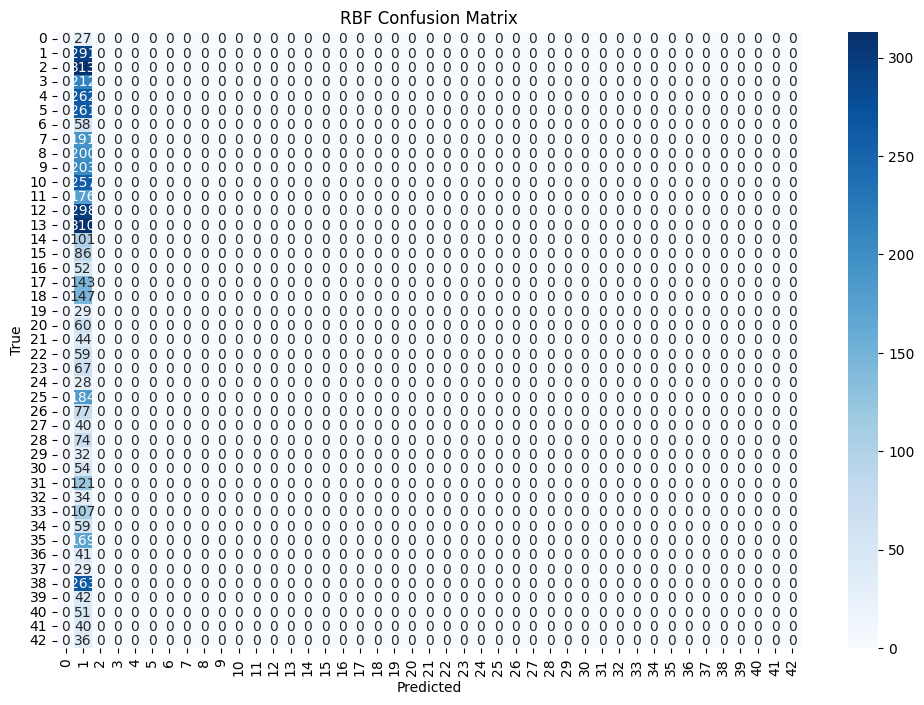

In [14]:
# Keras ile RBF modeli oluşturulacak
# RBF Katmanı Tanımı
class RBFLayer(Layer):
    def __init__(self, units, gamma=1.0, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = tf.constant(gamma, dtype=tf.float32)

    def build(self, input_shape):
        self.centers = self.add_weight(name='centers',
                                       shape=(self.units, input_shape[-1]),
                                       initializer='random_normal',
                                       trainable=True)
        self.built = True

    def call(self, inputs):
        # RBF fonksiyonu: e^(-gamma * ||x - c||^2)
        diff = tf.expand_dims(inputs, axis=1) - self.centers
        l2 = tf.reduce_sum(tf.square(diff), axis=-1)
        return tf.exp(-self.gamma * l2)

# Unit 100 gamma 0.5 veriliyor, aktivasyon fonksiyonu olarak softmax kullanılıyor
model = Sequential([
    RBFLayer(units=100, gamma=0.5),  # RBF Katmanı
    Dense(43, activation='softmax')  # Çıkış katmanı
])

# Modeli derliyoruz
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Modeli eğitiyoruz
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Tahminler yapılıyor
y_pred_rbf = model.predict(X_test)
y_pred_rbf_classes = np.argmax(y_pred_rbf, axis=1)

# Performans değerlendirme yapılıyor
print("RBF Classification Report:")
print(classification_report(y_test, y_pred_rbf_classes))

# Karışıklık matrisini oluştur
cm_rbf = confusion_matrix(y_test, y_pred_rbf_classes)

# Karışıklık matrisini Görselleştiriyoruz
plt.figure(figsize=(12, 8))
sns.heatmap(cm_rbf, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('RBF Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [23]:
# RBF Modeli Farklı Hiperparametreler ile test ediliyor
gamma_values = [0.1, 0.5, 1.0, 5.0]  # Gamma değerleri
units_values = [50, 100, 200]         # Nöron sayısı
batch_sizes = [16, 32]                # Batch boyutu
learning_rates = [0.001, 0.01]        # Öğrenme oranı

best_accuracy = 0
best_params = None

for gamma in gamma_values:
    for units in units_values:
        for batch_size in batch_sizes:
            for lr in learning_rates:
                print(f"Testing: gamma={gamma}, units={units}, batch_size={batch_size}, lr={lr}")

                # Modeli oluştur
                model = Sequential([
                    RBFLayer(units=units, gamma=gamma),
                    Dense(43, activation='softmax')  # Çıkış katmanı
                ])

                # Optimizasyonu ayarlıyoruz
                optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

                # Modeli derliyoruz
                model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

                # Modeli eğitiyoruz
                history = model.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_split=0.2, verbose=0)

                # Doğrulama doğruluğunu alıyoruz
                val_accuracy = max(history.history['val_accuracy'])
                print(f"Validation Accuracy: {val_accuracy:.4f}")

                # En iyi doğruluğu ve parametreleri saklıyoruz
                if val_accuracy > best_accuracy:
                    best_accuracy = val_accuracy
                    best_params = {'gamma': gamma, 'units': units, 'batch_size': batch_size, 'learning_rate': lr, 'accuracy' : val_accuracy,}

# En iyi doğruluğu ve parametreleri yazdırıyoruz
print("Best Parameters:", best_params)
print("Best Validation Accuracy:", best_accuracy)

Testing: gamma=0.1, units=50, batch_size=16, lr=0.001
Validation Accuracy: 0.0554
Testing: gamma=0.1, units=50, batch_size=16, lr=0.01
Validation Accuracy: 0.0556
Testing: gamma=0.1, units=50, batch_size=32, lr=0.001
Validation Accuracy: 0.0549
Testing: gamma=0.1, units=50, batch_size=32, lr=0.01
Validation Accuracy: 0.0556
Testing: gamma=0.1, units=100, batch_size=16, lr=0.001
Validation Accuracy: 0.0556
Testing: gamma=0.1, units=100, batch_size=16, lr=0.01
Validation Accuracy: 0.0556
Testing: gamma=0.1, units=100, batch_size=32, lr=0.001
Validation Accuracy: 0.0549
Testing: gamma=0.1, units=100, batch_size=32, lr=0.01
Validation Accuracy: 0.0556
Testing: gamma=0.1, units=200, batch_size=16, lr=0.001
Validation Accuracy: 0.0556
Testing: gamma=0.1, units=200, batch_size=16, lr=0.01
Validation Accuracy: 0.0561
Testing: gamma=0.1, units=200, batch_size=32, lr=0.001
Validation Accuracy: 0.0549
Testing: gamma=0.1, units=200, batch_size=32, lr=0.01
Validation Accuracy: 0.0556
Testing: gamma

Training model with best parameters: gamma=0.1, units=200, batch_size=16, learning_rate=0.01
Epoch 1/20
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.0525 - loss: 3.5621 - val_accuracy: 0.0549 - val_loss: 3.5189
Epoch 2/20
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.0557 - loss: 3.4951 - val_accuracy: 0.0558 - val_loss: 3.5170
Epoch 3/20
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.0537 - loss: 3.4976 - val_accuracy: 0.0556 - val_loss: 3.5206
Epoch 4/20
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.0539 - loss: 3.4996 - val_accuracy: 0.0554 - val_loss: 3.5209
Epoch 5/20
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.0602 - loss: 3.5025 - val_accuracy: 0.0504 - val_loss: 3.5181
Epoch 6/20
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.0538 - loss: 3.4994 - val_accuracy: 0.0549 - val_loss: 3.5189
Epoch 7/20
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.0528 - loss: 3.5063 - val_accuracy: 0.0556 - val_loss: 3.51

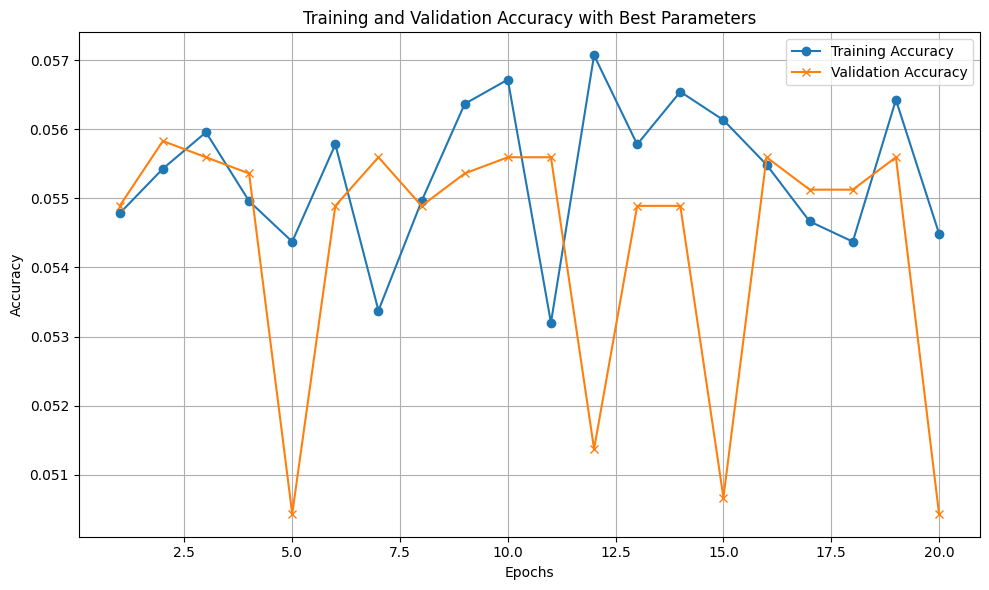

In [31]:
# RBF modeli Yukarıda hesaplanan En iyi parametreler ile yeniden eğitiliyor
# ve çıkan sonuçlara göre grafik çizdiriliyor
best_gamma = best_params['gamma']
best_units = best_params['units']
best_batch_size = best_params['batch_size']
best_lr = best_params['learning_rate']

print(f"Training model with best parameters: gamma={best_gamma}, units={best_units}, batch_size={best_batch_size}, learning_rate={best_lr}")

# Modeli oluştur
best_model = Sequential([
    RBFLayer(units=best_units, gamma=best_gamma),
    Dense(43, activation='softmax')  # Çıkış katmanı
])

# Optimizasyonu ayarlıyoruz
best_optimizer = tf.keras.optimizers.Adam(learning_rate=best_lr)

# Modeli derliyoruz
best_model.compile(optimizer=best_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# En iyi modelin eğitimini yapıyoruz
best_history = best_model.fit(X_train, y_train, epochs=20, batch_size=best_batch_size, validation_split=0.2, verbose=1)

# Eğitim ve doğrulama doğruluklarını alıyoruz
epochs = range(1, 21)  # 20 epoch
train_accuracy = best_history.history['accuracy']
val_accuracy = best_history.history['val_accuracy']

# Grafik oluştur
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Eğitim doğruluğu
plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o')

# Doğrulama doğruluğu
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='x')

plt.title("Training and Validation Accuracy with Best Parameters")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [19]:
# MLP ve RBF sonuçlarını;
# Accuracy
# Precision
# Recall
# F1-Score
# parametrelerine göre tablo olarak yazdırıyoruz
results = pd.DataFrame({
    "Model": ["MLP", "RBF"],
    "Accuracy": [accuracy_score(y_test, y_pred_mlp), accuracy_score(y_test, y_pred_rbf_classes)],
    "Precision": [precision_score(y_test, y_pred_mlp, average='weighted'),
                  precision_score(y_test, y_pred_rbf_classes, average='weighted')],
    "Recall": [recall_score(y_test, y_pred_mlp, average='weighted'),
               recall_score(y_test, y_pred_rbf_classes, average='weighted')],
    "F1-Score": [f1_score(y_test, y_pred_mlp, average='weighted'),
                 f1_score(y_test, y_pred_rbf_classes, average='weighted')]
})

print(results)



  Model  Accuracy  Precision    Recall  F1-Score
0   MLP  0.968844   0.969588  0.968844  0.968890
1   RBF  0.054617   0.002983  0.054617  0.005657


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Bu sonuçlara göre modellerin karşılaştırmasını aşağıdaki gibi yapabiliriz.
- MLP modeli doğru tahmin (accuracy) oranında % 96.88 e karşılık % 5.46 oranı ile çok yüksek bir doğruluk gösteriyor.
- Bu sonuçlar yanlış pozitif ve gerçek pozitiflerin tahminlerinde de benzer sonuçlar üretmiş görünüyor. Yani MLP modeli oldukça başarılı iken RBF modeli oldukça başarısız görünüyor.

# RBF Modelinin kötü performansının muhtemel sebepleri şunlar olabilir.
- RBF modeli genellikle küçük ve homojen veri setlerinde başarılıdır, ancak TSRB veri seti büyük, karmaşık ve çok boyutludur. Bu nedenle, bu veri seti RBF'nin doğal yapısına uygun değildir.
- Bir diğer sebep te benim yanlış gamma değeri kullanmam yada veri setini ölçeklendirme işlemini doğru yapamamam da olabilir.